In [1]:
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *

In [2]:
import torch.nn.functional as F, matplotlib as mpl
from pathlib import Path
from operator import attrgetter, itemgetter
from contextlib import contextmanager

from torch import torch, nn, optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [3]:
def set_seed(seed):
    torch.use_deterministic_algorithms(True)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [4]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, kernel_size=ks, stride=2, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [6]:
def cnn_layers(): return [
     conv(1, 8, ks=5),              #14x14
     conv(8, 16),                   #7x7
     conv(16, 32),                  #4x4
     conv(32, 64),                  #2x2
     conv(64, 10, act=False),       #1x1
     nn.Flatten()]

In [7]:
from torcheval.metrics import MulticlassAccuracy

In [8]:
metrics = MetricsCB(accuracy = MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [9]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.153,2.301,0,train
0.191,2.145,0,eval


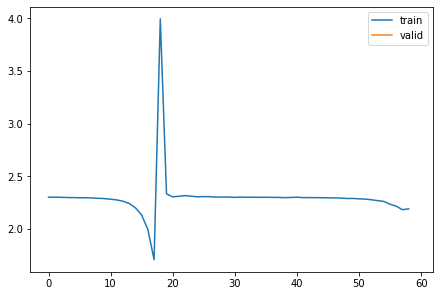

In [10]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

In [11]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x
    
    def __iter__(self): return iter(self.layers) #added to make model iterable, we can do for layer in model

accuracy,loss,epoch,train
0.153,2.301,0,train
0.191,2.145,0,eval


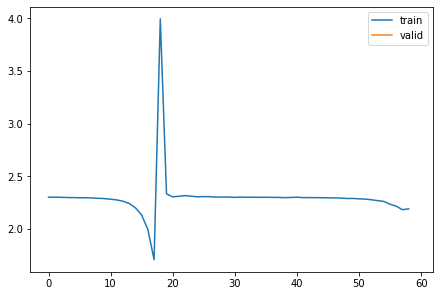

In [12]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

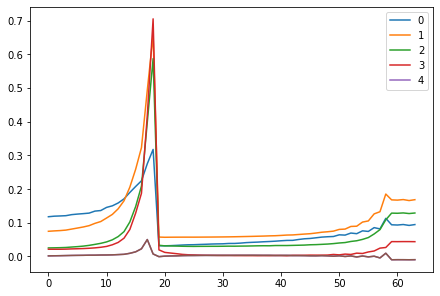

In [13]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

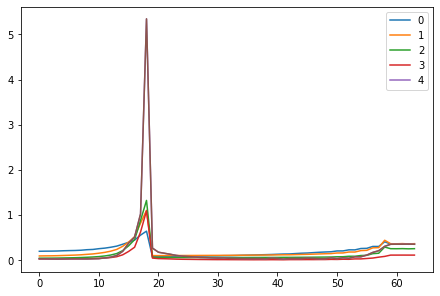

In [14]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

In [15]:
for layer in model:
    print(layer) #it'll throw "model is not iterable if __iter__ is not defined"

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
)
Sequential(
  (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
Flatten(start_dim=1, end_dim=-1)


In [16]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [17]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [18]:
from functools import partial

act_means = [[] for _ in model]
act_stds = [[] for _ in model]

def append_stats(i, *args):
    module, inp, output = args
    act_means[i].append(to_cpu(output).mean())
    act_stds[i].append(to_cpu(output).std())

for i, m in enumerate(model):
    m.register_forward_hook(partial(append_stats, i))

In [19]:
# def append_stats(i, module, inp, output):
#     act_means[i].append(to_cpu(output).mean())
#     act_stds[i].append(to_cpu(output).std())

# for i, m in enumerate(model):
#     m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.153,2.301,0,train
0.191,2.145,0,eval


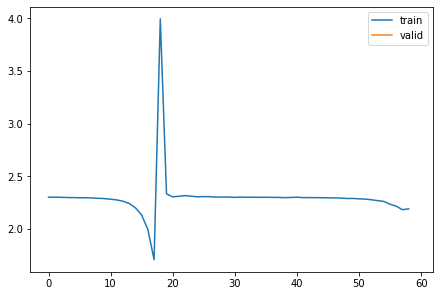

In [20]:
fit(model)

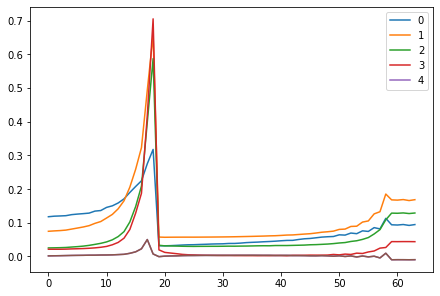

In [21]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

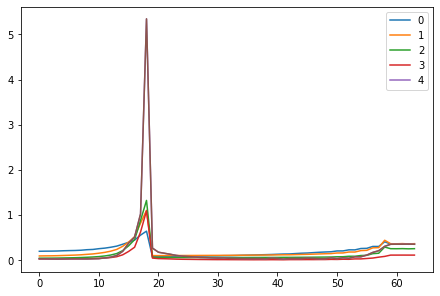

In [22]:
for o in act_stds: plt.plot(o)
plt.legend(range(5));

#### Understanding 'partial' function

In [23]:
def add(a, b, c):
    return a + b + c

In [24]:
add_10 = partial(add, 10)
add_10(20, 30)

60

In [25]:
add_10_5 = partial(add_10, 5)
add_10_5(2)

17

In [26]:
add_10_5 = partial(add, 10, 5)
add_10_5(2)

17

### Understanding \_\_new\_\_

partial uses \_\_new\_\_ to store and initialize attributes, so it's important to understand how it works

In [27]:
class Myclass:
    def __new__(cls, x):
        obj = super().__new__(cls)
        obj.x = x  # Attribute initialization *inside* __new__
        return obj
    
m = Myclass(10)
m.x

10

In [28]:
class Hook:
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()
    

In [29]:
def activation_stats(hook, mod, inp, out):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    acts = to_cpu(out)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [30]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [31]:
hooks = [Hook(l, activation_stats) for l in model[:5].children()]
hooks

accuracy,loss,epoch,train
0.153,2.301,0,train
0.191,2.145,0,eval


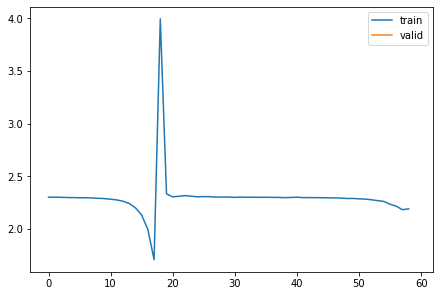

In [32]:
learn = fit(model)

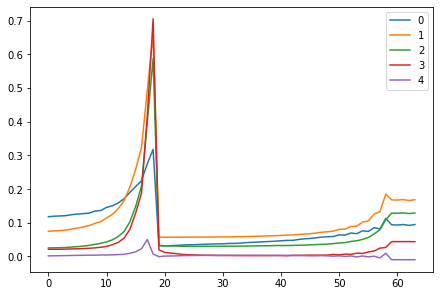

In [33]:
for h in hooks:
    plt.plot(h.stats[0])
plt.legend(range(5))

In [34]:
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [35]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.153,2.301,0,train
0.191,2.145,0,eval


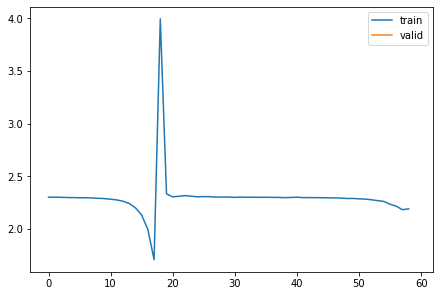

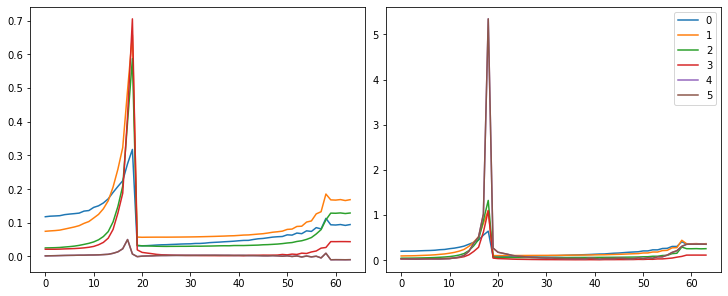

In [36]:
with Hooks(model, activation_stats) as hooks:
    fit(model)
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0,1: axs[i].plot(h.stats[i])
    plt.legend(range(6));

### Without inheriting from the list

If we don't inherit from the list then we need to store a list as a separate attribute and work with that, inheriting is lot more elegant. We do not need \_\_delitem\_\_ because that was being inherited from the list

In [37]:
class Hooks:
    def __init__(self, ms, f): self.hooks = [Hook(m, f) for m in ms]
    def __enter__(self, *args): return self.hooks
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def remove(self):
        for h in self.hooks: h.remove()

In [38]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.153,2.301,0,train
0.191,2.145,0,eval


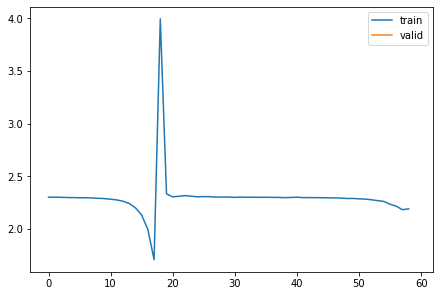

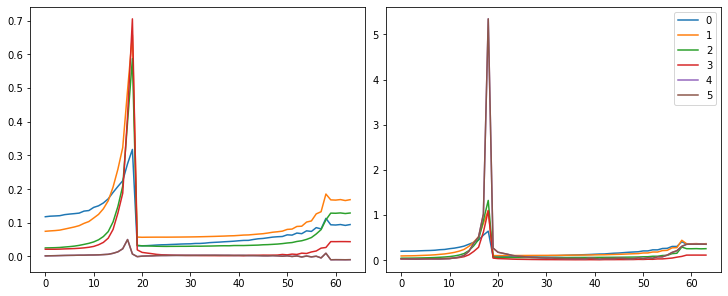

In [39]:
with Hooks(model, activation_stats) as hooks:
    fit(model)
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0,1: axs[i].plot(h.stats[i])
    plt.legend(range(6));

### Issues with our Hook's class

It's not a list and we can't index into it. So we need to define /_/_getitem/_/_

In [40]:
hooks = Hooks(model, activation_stats); type(hooks)

__main__.Hooks

In [41]:
# for hook in hooks:
#     print(hook)

TypeError: 'Hooks' object is not iterable

In [ ]:
#hooks[0]

In [42]:
class Hooks:
    def __init__(self, ms, f): self.hooks = [Hook(m, f) for m in ms]
    def __enter__(self, *args): return self.hooks
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self.hooks[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self.hooks: h.remove()
        
    def __getitem__(self, i): return self.hooks[i]

Now we can index into it

In [43]:
hooks = Hooks(model, activation_stats)
hooks[0]

Even though we have not deined an \_\_iter\_\_ it still behaves as an iterator and we can use a for loop, but we should add one to be more explicit. We'll also add \_\_len\_\_

In [44]:
hooks = Hooks(model, activation_stats)
for hook in hooks:
    print(hook)

So much effort just to not inherit from the list but learned a lot :p

In [45]:
class Hooks:
    def __init__(self, ms, f): self.hooks = [Hook(m, f) for m in ms]
    def __enter__(self, *args): return self.hooks
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self.hooks[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self.hooks: h.remove()
        
    def __getitem__(self, i): return self.hooks[i]
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

    def __delitem__(self, i):
        self.hooks[i].remove()
        del self.hooks[i]

### Context Managers

In [46]:
import time

class Timer:
    def __enter__(self, *args):
        print('Starting now!')
        return self # we need to return self to use it as 'timer'
    
    def __exit__(self, *args):
        self.end = time.time()
        print(f"Elapsed: {self.end - self.start:.4f} sec")
        
    def wait(self, i):
        self.start = time.time()
        time.sleep(i)
        print(f'Slept for {i} seconds')

with Timer() as t:
    t.wait(2)

Starting now!
Slept for 2 seconds
Elapsed: 2.0011 sec


In [47]:
class AdvanceTimer:
    def __enter__(self):
        self.start = time.time()
        self.checkpoints = []
        self.names = []
        print('Starting now!')
        return self   # Do not forget to return it!!!
        
    def __exit__(self, *args):
        end = time.time()
        print(f'Total time elapsed: {(end - self.start):.2f}')
        
    def checkpoint(self, name):
        now = time.time()
        print(f'Processin step: {name}')
        if self.checkpoints:
            print(f'Time elapsed since last checkpoint: {self.names[-1]}: {(now - self.checkpoints[-1]):.2f}')
        else:
            print(f'Time elapsed since start: {(now - self.start):.2f}')
        self.checkpoints.append(now)
        self.names.append(name)

In [48]:
with AdvanceTimer() as at:
    
    time.sleep(2)
    at.checkpoint('Reading data')
    
    time.sleep(2)
    at.checkpoint('Creating batches')
    
    time.sleep(2)
    at.checkpoint('Starting training')

Starting now!
Processin step: Reading data
Time elapsed since start: 2.00
Processin step: Creating batches
Time elapsed since last checkpoint: Reading data: 2.00
Processin step: Starting training
Time elapsed since last checkpoint: Creating batches: 2.00
Total time elapsed: 6.01


In [49]:
def append_stats(hook, mod, inp, out):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    acts = to_cpu(out)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40, 0, 10))

In [50]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.153,2.301,0,train
0.191,2.145,0,eval


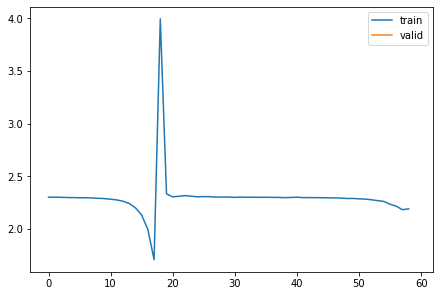

In [51]:
with Hooks(model, append_stats) as hooks: fit(model)

In [52]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

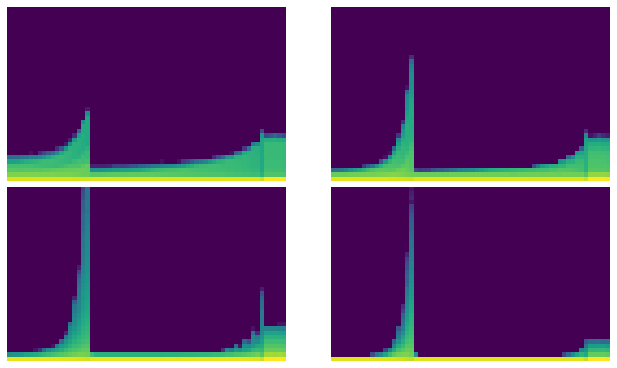

In [59]:
fig, axes = subplots(2,2, figsize=(9,5))
for ax, h in zip(axes.flatten(), hooks[:4]):
    show_image(get_hist(h), ax, origin='lower')